In [ ]:
import os
import pandas as pd
import csv
import numpy as np
import string
import torch

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# configurations
embedding_dim = 20
learning_rate = 0.01
batch_size = 1024

In [ ]:
# fancy stuff
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
wordToIndexDictionary = ''
with open('/content/gdrive/MyDrive/PyTorch/data/pa3_parta/wordToIndexDictionary.txt', 'r') as f:
    for i in f.readlines():
        wordToIndexDictionary = i

wordToIndexDictionary = eval(wordToIndexDictionary)

indexToWordDictionary = ''
with open('/content/gdrive/MyDrive/PyTorch/data/pa3_parta/indexToWordDictionary.txt', 'r') as f:
    for i in f.readlines():
        indexToWordDictionary = i

indexToWordDictionary = eval(indexToWordDictionary)

unique_words = []

with open('/content/gdrive/MyDrive/PyTorch/data/pa3_parta/unique_words.txt', 'r') as filehandle:
    for line in filehandle:
        unique_words.append(line[:-1])

vocab_size = len(unique_words)

trainset = pd.read_csv("/content/gdrive/MyDrive/PyTorch/data/pa3_parta/SkipGram_Train.csv")
testset = pd.read_csv("/content/gdrive/MyDrive/PyTorch/data/pa3_parta/SkipGram_Test.csv")

trainloader = torch.utils.data.DataLoader(trainset.values, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset.values, batch_size=batch_size, shuffle=True)

In [ ]:
%cd '/content/gdrive/MyDrive/PyTorch'

/content/gdrive/MyDrive/PyTorch


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

In [ ]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, vocab_size)
        self.activation_function = nn.LogSoftmax(dim = -1)  

    def forward(self, inputs):
        out = self.embeddings(inputs)
        out = self.linear1(out)
        return self.activation_function(out)

    def get_word_embedding(self, word):
        word = torch.tensor([wordToIndexDictionary[word]])
        return self.embeddings(word)

In [ ]:
skip_gram = SkipGram(vocab_size, embedding_dim)
skip_gram.to(device)
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(skip_gram.parameters(), lr=learning_rate)

In [ ]:
def train(model, trainloader, val_iterator, optimizer, loss_function, epochs, results):
  
  for j in range(epochs):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    print(color.BOLD + "Training for epoch = " + color.END, j)
    for trainload in enumerate(tqdm(trainloader)):

        y_true = trainload[1][:,1].to(device)

        y_pred = model.forward(trainload[1][:,0].to(device))

        loss = loss_function(y_pred, y_true.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    print(f"[{j}/{epochs}] : epoch_loss: {epoch_loss / len(trainloader):.4f}")
    val_loss = evaluate(model, val_iterator, loss_function)

    train_loss = epoch_loss / len(trainloader)
    results = results.append({"Epoch": (j+1), \
                            "Train Loss": train_loss, \
                            "Val Loss": val_loss},ignore_index=True)
    
    torch.save(model.state_dict(), f"./data/Sentiment_models/skip/skip_model_{j+1}.pth")
    results.to_csv(f"./data/Sentiment_models/skip/skip_Results_{embedding_dim}.csv")


  return train_loss

In [ ]:
def evaluate(model, testloader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    print("Validation")
    with torch.no_grad():
        for testload in enumerate(tqdm(testloader)):

            y_true = testload[1][:,1].to(device)

            y_pred = model.forward(testload[1][:,0].to(device))

            loss = loss_function(y_pred, y_true.to(device))
            
            epoch_loss += loss.item()

    print(f"val_loss: {epoch_loss / len(testloader):.4f}")
    print("--------------------------------------------------------------------")
    print();print()
    return epoch_loss / len(testloader)

In [ ]:
epochs = 5
results = pd.DataFrame(columns=["Epoch","Train Loss","Val Loss"])
train(skip_gram, trainloader, testloader, optimizer, loss_function, epochs, results)

Training for epoch =  0



[0/5] : epoch_loss: 11.4261
Validation



val_loss: 11.2588
--------------------------------------------------------------------


Training for epoch =  1


Buffered data was truncated after reaching the output size limit.

In [ ]:
# Plot train and test accuracy and losses

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(f'./data/Sentiment_models/skip/skip_Results_20.csv')
df.head()

,Unnamed: 0,Epoch,Train Loss,Val Loss
0,0,1.0,11.426146,11.258834
1,1,2.0,11.173741,11.098555
2,2,3.0,11.030794,10.969553


In [ ]:
train_loss = df['Train Loss'].values
val_loss = df['Val Loss'].values

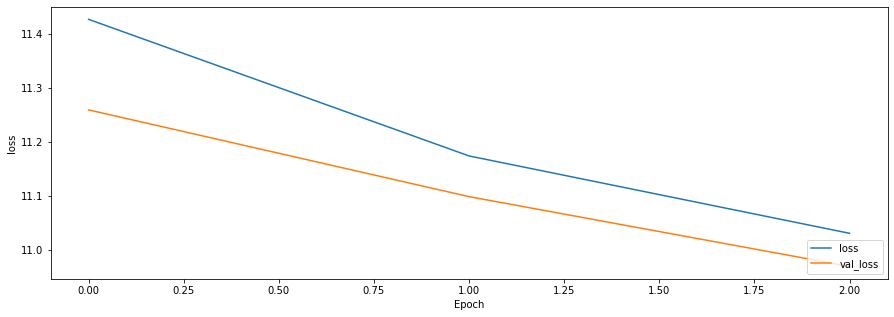

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(train_loss, label='loss')
plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

plt.show()